# Reduced fragment library

## Aim of this notebook

The fragment library resulting from the KinFragLib fragmentation procedure comprises of about 3000 fragments. Ultimately, we want to demonstrate how this library can be used for recombining ligands. Before this can be done, we need to address two considerations:

1. Remove all fragments that are not useful in a recombination, i.e. duplicates, fragments in pool X, fragments without dummy atoms, and fragments with dummy atoms only connecting to pool X. Also remove all AP fragments that show no hydrogen bond donors/acceptors and/or aliphatic/aromatic rings (not hinge-like).
2. Select a diverse set of fragments (per subpocket) for recombination to (i) save computational cost and (ii) avoid recombination of highly similar fragments.

## Table of contents

1. Load fragment library
2. Filter fragment library
3. Save filtered fragment library 
4. Cluster and select filtered fragments (get diverse set of fragments)
5. Look at selected fragments
6. Save reduced fragment library 

In [162]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
import math
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, Lipinski, PandasTools
from IPython.core.display import HTML

from kinfraglib import utils

In [164]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

## Globals

In [165]:
# Path to data
HERE = Path(_dh[-1])
PATH_DATA = HERE / '../data'

# Butina clustering: distance cutoff
DISTANCE_CUTOFF = 0.6

# Select fragments from clusters: Most common fragment per cluster (if mulitple most common fragments, select the one most similar to cluster centroid)
# (A) Select always one fragment per cluster (cluster centroid)
#N_REPRESENTED_FRAGMENTS = None
# (B) Select top X most common fragments per cluster, whereby X is depending on cluster size (20 clustered fragments will be represented by one selected fragment)
N_REPRESENTED_FRAGMENTS = 10

# Do we want to include fragment from singleton clusters?
INCLUDE_SINGLETONS = True

In [166]:
def save_fragment_library_to_sdfs(path_output, fragment_library_concat):
    """
    Save fragment library to file (for each subpocket sdf file).
    
    Parameters
    ----------
    path_output : str or pathlib.Path
        Path to output folder for sdf files.
    fragment_library_concat : pandas.DataFrame
        Fragment library data for one or multiple subpockets.
    """
    
    path_output = Path(path_output)
    path_output.mkdir(parents=True, exist_ok=True)
    
    for subpocket, fragments in fragment_library_concat.groupby('subpocket'):
        
        with open(path_output / f'{subpocket}.sdf', 'w') as f:
            w = Chem.SDWriter(f)
            for mol in fragments.ROMol_original:
                w.write(mol)
            w.close()

## 1. Load fragment library

In [167]:
fragment_library = utils.read_fragment_library(PATH_DATA / 'fragment_library')

In [168]:
fragment_library_concat = pd.concat(fragment_library).reset_index(drop=True)
print(fragment_library_concat.shape)
# NBVAL_CHECK_OUTPUT

(9304, 15)



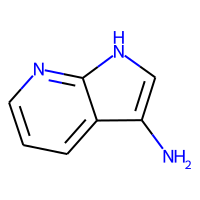
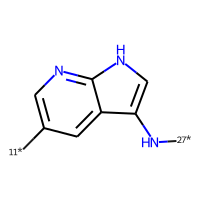
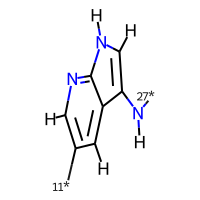
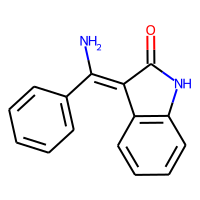
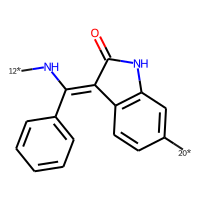
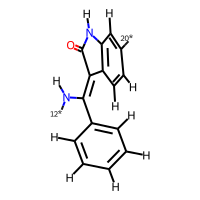

In [169]:
HTML(fragment_library_concat.head(2).to_html(notebook=True))

In [170]:
fragment_library_concat.groupby('subpocket', sort=False).size()
# NBVAL_CHECK_OUTPUT

subpocket
AP    3182
FP    2338
SE    1916
GA    1275
B1     121
B2     112
X      360
dtype: int64

## 2. Filter fragment library

Filter steps:

1. Remove pool X
2. Deduplicate fragment library (per subpocket)
3. Remove fragments without dummy atoms (unfragmented ligands)
4. Remove all fragments that connect only to pool X
5. Keep "Rule of Three (Ro3)" compliant fragments (fragment-likeness)
6. Filter AP subpocket fragments (typical hinge-like)

### 2.1. Remove pool X

In [171]:
# Remove pool X
fragment_library_concat_filtered = fragment_library_concat[
    fragment_library_concat.subpocket != 'X'
].copy()
print(fragment_library_concat_filtered.shape)
fragment_library_concat_filtered.subpocket.unique()
# NBVAL_CHECK_OUTPUT

(8944, 15)


array(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'], dtype=object)

### 2.2. Deduplicate fragment library (per subpocket)

In [172]:
# Get fragment count (by SMILES) per subpocket
fragment_count = fragment_library_concat_filtered.groupby(
    ['subpocket', 'smiles'],
    sort=False
).size()

In [173]:
# Get first occurrence of SMILES per subpocket
fragment_library_concat_filtered = fragment_library_concat_filtered.groupby(
    ['subpocket', 'smiles'],
    sort=False
).first()

In [174]:
# Add fragment count to these representative fragments
fragment_library_concat_filtered['fragment_count'] = fragment_count
fragment_library_concat_filtered.reset_index(inplace=True)

print(fragment_library_concat_filtered.shape)
# NBVAL_CHECK_OUTPUT

(3569, 16)



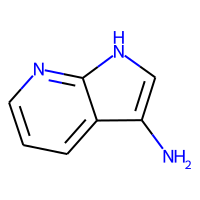
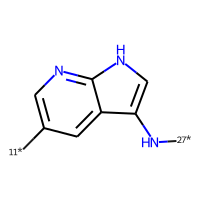
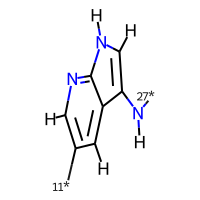
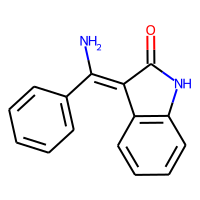
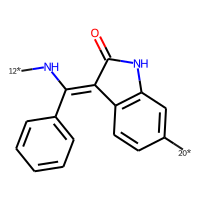
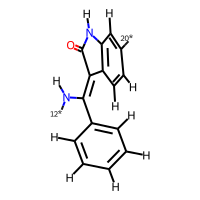

In [175]:
HTML(fragment_library_concat_filtered.head(2).to_html(notebook=True))

In [176]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()
# NBVAL_CHECK_OUTPUT

subpocket
AP    1308
FP    1087
SE     716
GA     352
B1      46
B2      60
dtype: int64

### 2.3. Remove fragments without dummy atoms (unfragmented ligands)

In [177]:
# Get fragments' (subpocket) connections 
fragment_library_concat_filtered['connections'] = utils.get_connections_by_fragment(fragment_library_concat_filtered).connections

In [178]:
# Unfragmented ligands?
bool_unfragmented_ligands = fragment_library_concat_filtered.connections.apply(lambda x: len(x) == 0)

In [179]:
# Remove unfragmented ligands
fragment_library_concat_filtered = fragment_library_concat_filtered[
    ~bool_unfragmented_ligands
].copy()
print(fragment_library_concat_filtered.shape)
# NBVAL_CHECK_OUTPUT

(3443, 18)


In [180]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()
# NBVAL_CHECK_OUTPUT

subpocket
AP    1182
FP    1087
SE     716
GA     352
B1      46
B2      60
dtype: int64

### 2.4. Remove all fragments that connect only to pool X

In [181]:
# Fragment connects only to pool X?
bool_only_pool_x_connections = fragment_library_concat_filtered.connections.apply(
    lambda x: all(  # All connections per fragment are X?
        [True if 'X' in i else False for i in x]  # Connections per fragment X or not?
    )
)

In [182]:
# Remove fragments that connect only to pool X
fragment_library_concat_filtered = fragment_library_concat_filtered[
    ~bool_only_pool_x_connections
].copy()
print(fragment_library_concat_filtered.shape)
# NBVAL_CHECK_OUTPUT

(3441, 18)


In [183]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()
# NBVAL_CHECK_OUTPUT

subpocket
AP    1182
FP    1086
SE     716
GA     352
B1      46
B2      59
dtype: int64

### 2.5. Keep "Rule of Three (Ro3)" compliant fragments (fragment-likeness)

Rule of Three criteria ([paper](https://www.sciencedirect.com/science/article/pii/S1359644603028319)):
- Molecular weight < 300 Da
- LogP <= 3
- Number of HBA <= 3 
- Number of HBD <= 3
- Number of rotatable bonds <= 3 
- Polar surface area (PSA) <= 60 $\mathring{A}$<sup>2</sup>

In [184]:
ro3 = fragment_library_concat_filtered.ROMol.apply(lambda x: utils.get_ro3_from_mol(x))

In [185]:
# Fragments fulfill all six Ro3 rules
bool_fulfill_ro3 = ro3.sum(axis=1) == 6

In [186]:
fragment_library_concat_filtered = fragment_library_concat_filtered[
    bool_fulfill_ro3
].copy()
print(fragment_library_concat_filtered.shape)
# NBVAL_CHECK_OUTPUT

(2424, 18)


In [187]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()
# NBVAL_CHECK_OUTPUT

subpocket
AP    595
FP    831
SE    591
GA    309
B1     43
B2     55
dtype: int64

### 2.6. Filter AP subpocket fragments (typical hinge-like)

For the AP subpocket, we only want to keep fragments that (similar to most '-nibs') have 
- at least one hydrogen bond donor (HBD) or acceptor (HBA) and
- at least one aromatic or aliphatic ring.

1. Add the number of HBD, HBA, (heavy atoms), aromatic and aliphatic rings for all fragments - use fragments with dummy atoms to avoid detection of HBDs at dummy atom neighboring atoms.

In [188]:
fragment_library_concat_filtered['hbd'] = fragment_library_concat_filtered.ROMol_dummy.apply(lambda x: Lipinski.NumHAcceptors(x))
fragment_library_concat_filtered['hba'] = fragment_library_concat_filtered.ROMol_dummy.apply(lambda x: Lipinski.NumHDonors(x))
fragment_library_concat_filtered['n_atoms'] = fragment_library_concat_filtered.ROMol_dummy.apply(lambda x: x.GetNumHeavyAtoms())
fragment_library_concat_filtered['n_aromatic_rings'] = fragment_library_concat_filtered.ROMol_dummy.apply(lambda x: Lipinski.NumAromaticRings(x))
fragment_library_concat_filtered['n_aliphatic_rings'] = fragment_library_concat_filtered.ROMol_dummy.apply(lambda x: Lipinski.NumAliphaticRings(x))

In [189]:
def draw_fragments_with_hinge_criteria_annotation(fragments, max_mols):
    """
    Draw fragments labeled with their number of HBDs, HBAs, aromatic and aliphatic rings.
    
    Parameters
    ----------
    fragments : pandas.DataFrame
        Fragments in DataFrame with columns ROMol_dummy (RDKit molecule with dummy atoms), hbd, hba, n_aromatic_rings, n_aliphatic_rings 
        (number of HBDs, HBAs, aromatic and aliphatic rings rings).
    max_mols : int
        Number of molecules displayed.
        
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of fragments.
    """
    
    if fragments.shape[0] == 0:
        raise ValueError(f'Input DataFrame has length 0 - no data available to be drawn.')
    
    print(f'#HBD | #HBA | #aromatic rings | #aliphatic rings | complex PDB ID | ligand PDB ID')
    image = Draw.MolsToGridImage(
        fragments.ROMol_dummy,
        maxMols=max_mols,
        molsPerRow=7,
        legends=fragments.apply(
            lambda x: f'{x.hbd} | {x.hba} | {x.n_aromatic_rings} | {x.n_aliphatic_rings} | {x.complex_pdb} | {x.ligand_pdb}',
            axis=1
        ).to_list()
    )
    
    return image

Example AP fragments with hinge criteria annotation (in order to check if number of HBA ect. are as expected:)
#HBD | #HBA | #aromatic rings | #aliphatic rings | complex PDB ID | ligand PDB ID


/opt/homebrew/Caskroom/mambaforge/base/envs/kinfraglib/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 14. Change the maxMols value to display more.
  warnings.warn(


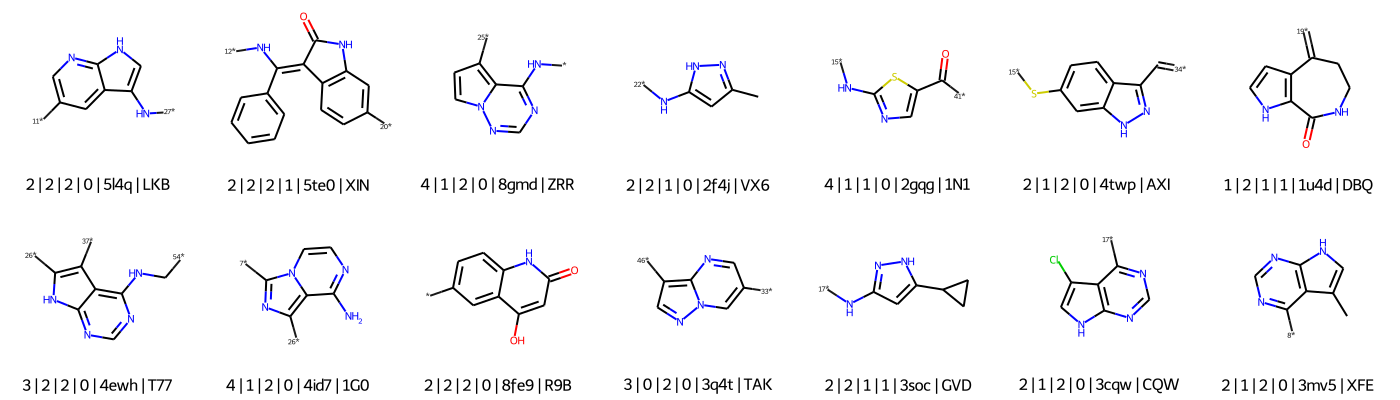

In [190]:
print('Example AP fragments with hinge criteria annotation (in order to check if number of HBA ect. are as expected:)')
draw_fragments_with_hinge_criteria_annotation(fragment_library_concat_filtered[fragment_library_concat_filtered.subpocket == 'AP'], max_mols=14)

2. Get index labels for fragments that do not show any HBDs, HBAs, aromatic and aliphatic rings.

Fragments that will be filtered out:
#HBD | #HBA | #aromatic rings | #aliphatic rings | complex PDB ID | ligand PDB ID


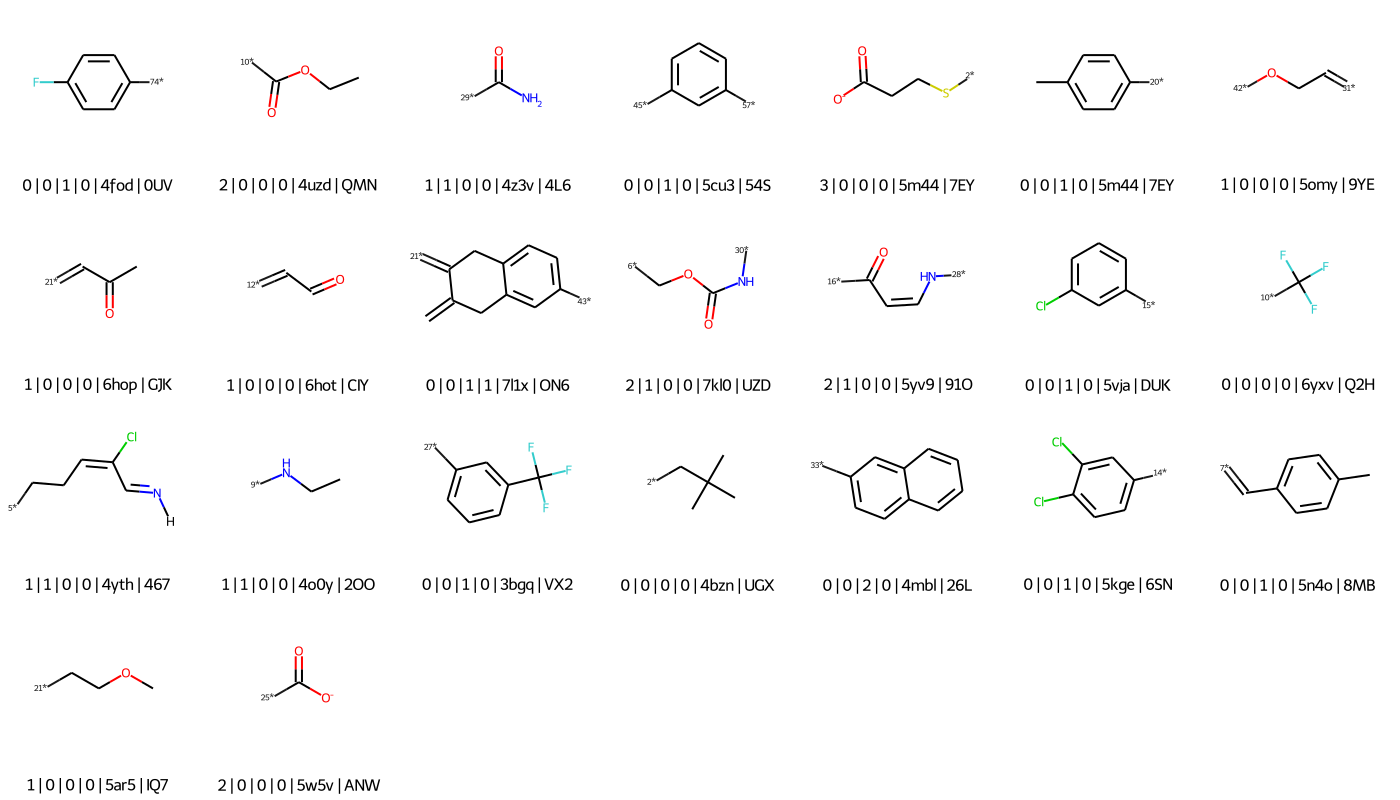

In [191]:
index_labels_hinge_unlike = fragment_library_concat_filtered[
    (fragment_library_concat_filtered.subpocket == 'AP') & 
    ((fragment_library_concat_filtered.hbd + fragment_library_concat_filtered.hba == 0) | 
    (fragment_library_concat_filtered.n_aromatic_rings + fragment_library_concat_filtered.n_aliphatic_rings == 0))
].index

print('Fragments that will be filtered out:')
draw_fragments_with_hinge_criteria_annotation(fragment_library_concat_filtered.loc[index_labels_hinge_unlike], max_mols=50)

Verify these filtered-out AP fragments (focus on those with H-bonds possibility only) by checking all fragments and annotated subpockets of the original ligand as well as it's interactions in KLIFS's 3D view to assess if the ligands really should not be considered for library design:

- Ligand has no typical hinge fragment  
  - 5m44  
  - 6hop  
  - 6hot  
  - 5yv9  
  - 4yth  
  - 5ar5  
- Ligand contains large 'not fragmentable' part
  - 5omy: FP fragment contains AP part  
  - 5w5v: SE fragment contains AP part  
- Corner cases: AP fragment is not correctly assigned (due to design choices) 
  - 3fdn: SE contains hinge binding fragment (visual inspection)  
  - 4uyn: GA contains part of hinge binding fragment (visual inspection)  
  - 4o0y: Ligand has two AP fragments (allowed in current implementation) of which one is the intended one, the one that is filtered out here is rather part of SE  

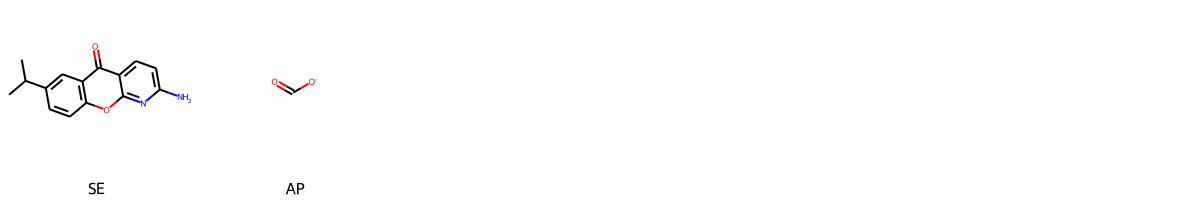

In [192]:
# Look at ligand fragmentation like this:
utils.draw_fragmented_ligand(fragment_library, '5w5v', 'ANW')

3. Drop these hinge-unlike fragments in AP.

In [193]:
fragment_library_concat_filtered.drop(
    labels=index_labels_hinge_unlike, 
    axis=0,
    inplace=True
)
fragment_library_concat_filtered.shape
# NBVAL_CHECK_OUTPUT

(2401, 23)

### 3. Save filtered fragment library

Save filtered fragment library as sdf files (one per subpocket).

In [194]:
save_fragment_library_to_sdfs(PATH_DATA / 'fragment_library_filtered', fragment_library_concat_filtered)

In [195]:
with open(PATH_DATA / 'fragment_library_filtered' / 'README.md', 'w') as f:
    f.write(
        f'# Filtered fragment library\n\n'
        f'The (full) fragment library resulting from the KinFragLib fragmentation procedure comprises of {fragment_library_concat.shape[0]} fragments, '
        f'which are the basis for exploring the subpocket-based chemical space of ligands co-crystallized with kinases '
        f'(see `data/fragment_library/`).\n\n'
        f'In order to prepare a library with fragments tailored for recombination, '
        f'we offer heare a filtered fragment library ({fragment_library_concat_filtered.shape[0]} fragments) based on the following filters:\n\n'
        f'1. Remove pool X\n'
        f'2. Deduplicate fragment library (per subpocket)\n'
        f'3. Remove fragments without dummy atoms (unfragmented ligands)\n'
        f'4. Remove all fragments that connect only to pool X\n'
        f'5. Keep "Rule of Three (Ro3)" compliant fragments (fragment-likeness)\n'
        f'6. Filter AP subpocket fragments (typical hinge-like)'
        f'\n\n'
        f'Please refer to the notebook `notebooks/3_1_fragment_library_reduced.ipynb` to check how the data was generated and/or use it as a starting point for customized protocols.'
    )

## 4. Cluster and select filtered fragments (get diverse set of fragments)

### Fragment clustering per subpocket

In [196]:
def cluster_fragments(fragments, cutoff):
    """
    Cluster fragments using the Butina algorithm with a given distance cutoff.
    
    Parameters
    ----------
    fragments : pandas.DataFrame
        Fragments.
    cutoff : float
        Distance cutoff Butina clustering.
        
    Returns
    -------
    pandas.DataFrame
        Clustered fragments, containing fragment details available from input plus cluster details (fragments' cluster IDs, cluster member ID, 
        cluster size, and molecule ID).
    """

    # Get fragments by subpocket
    fragments = fragments.copy()
    fragments.reset_index(inplace=True, drop=True)
    fragments.index.name = 'molecule_id'

    # Cluster molecules 
    clustered_fragments = utils.cluster_molecules(fragments.ROMol, cutoff)
    #clustered_fragments = utils.cluster_molecules(fragments.ROMol_dummy, cutoff)  # (including dummy atoms)
    
    # Concatenate cluster metadata with fragment details
    clustered_fragments = fragments.merge(
        clustered_fragments,
        on='molecule_id',
    )
    
    return clustered_fragments

### Fragment selection per subpocket

In [197]:
def select_fragments_from_clusters(clustered_fragments, n_represented_fragments=None):
    """
    Select fragments from clusters - two options: 
    (A) Get most common fragment. In case of mulitple most common fragments, select the one that is most similar to cluster centroid.
    (B) Get top X most common fragments, whereby X depends on the cluster size (more fragments will be selected from larger clusters).
    
    Parameters
    ----------
    clustered_fragments : pandas.DataFrame
        Fragments with cluster details (cluster ID, cluster size, cluster member ID, and molecule ID).
    n_represented_fragments : None or int
        Default: Select first fragment per sorted cluster (None). 
        Alternative: Select top X fragments per sorted cluster, whereby X depends on cluster size (n_cluster_fragments): 
        X = n_cluster_fragments / n_represented_fragments.
        
    Returns
    -------
    pandas.DataFrame
        Fragments selected from clusters, including cluster IDs, cluster member ID, cluster size, and molecule ID.
    """
    
    # Sort DataFrame by cluster ID (ascending), fragment count (descending), and cluster member ID (ascending)
    # Note member ID: the smaller, the more similar to cluster centroid
    clustered_fragments.sort_values(
        ['cluster_id', 'fragment_count', 'cluster_member_id'], 
        ascending=[True, False, True], 
        inplace=True
    )

    # Select fragment per cluster by (i) fragment count and (i) similarity to cluster centroids (cluster member ID):
    
    # Option A: Select first fragment per sorted cluster
    if n_represented_fragments is None:
        selected_fragments = clustered_fragments.groupby('cluster_id', sort=False).first()
        selected_fragments.reset_index(inplace=True)
        selected_fragments['cluster_size'] = clustered_fragments.groupby('cluster_id', sort=False).size()
    
    # Option B: Select top X fragments per sorted cluster, whereby X depends on the cluster size (e.g. per 20 fragments select one)
    else:
        selected_fragments = clustered_fragments.groupby('cluster_id', sort=False).apply(
            lambda x: x.head(math.ceil(len(x) / n_represented_fragments))
        )
        selected_fragments.reset_index(inplace=True, drop=True)
        selected_fragments['cluster_size'] = [clustered_fragments.groupby('cluster_id', sort=False).size().loc[cluster_id] for cluster_id in selected_fragments.cluster_id]
    
    print(f'Number of selected fragments / clusters / inital fragments: {selected_fragments.shape[0]} / {clustered_fragments.cluster_id.unique().shape[0]} / {clustered_fragments.shape[0]}')
    
    return selected_fragments

### Fragment clustering and selection for all subpockets (individually)

In [198]:
def select_fragments_from_clusters_all_subpockets(fragment_library_concat, cutoff, n_represented_fragments=None):
    """
    Cluster fragments and select cluster representatives for mulitple subpockets individually:
    1. Cluster fragments using the Butina algorithm with a given distance cutoff.
    2. Select fragments from clusters - two options: 
       (A) Get most common fragment. In case of mulitple most common fragments, select the one that is most similar to cluster centroid.
       (B) Get top X most common fragments, whereby X depends on the cluster size (more fragments will be selected from larger clusters).
    
    Parameters
    ----------
    fragment_library_concat : pandas.DataFrame
        Fragment library data for one or multiple subpockets.
    cutoff : float
        Distance cutoff Butina clustering.
    n_represented_fragments : None or int
        Default: Select first fragment per sorted cluster (None). 
        Alternative: Select top X fragments per sorted cluster, whereby X depends on cluster size (n_cluster_fragments): 
        X = n_cluster_fragments / n_represented_fragments.
    
    Returns
    -------
    pandas.DataFrame
        Fragments selected from clustering, including cluster IDs, cluster member ID, cluster size, and molecule ID (clustering per subpocket individually).   
    """
    
    selected_fragments_subpockets = {}

    for subpocket, fragments in fragment_library_concat.groupby('subpocket', sort=False):
        
        print(f'\nSubpocket: {subpocket}')
        
        clustered_fragments_subpocket = cluster_fragments(fragments, cutoff)
        selected_fragments_subpocket = select_fragments_from_clusters(clustered_fragments_subpocket, n_represented_fragments)
        
        selected_fragments_subpocket['subpocket'] = subpocket
        selected_fragments_subpockets[subpocket] = selected_fragments_subpocket

    # Concatenate cluster centroids for all subpockets
    selected_fragments = pd.concat(selected_fragments_subpockets).reset_index(drop=True)
    
    return selected_fragments

In [199]:
selected_fragments = select_fragments_from_clusters_all_subpockets(
    fragment_library_concat_filtered, 
    DISTANCE_CUTOFF, 
    n_represented_fragments=N_REPRESENTED_FRAGMENTS
)
# NBVAL_CHECK_OUTPUT


Subpocket: AP
Number of molecules: 572
Threshold:  0.6
Number of clusters:  138
# Clusters with only 1 molecule:  79
# Clusters with more than 5 molecules:  23
# Clusters with more than 25 molecules:  3
# Clusters with more than 100 molecules:  0
Number of selected fragments / clusters / inital fragments: 163 / 138 / 572

Subpocket: FP
Number of molecules: 831
Threshold:  0.6
Number of clusters:  208
# Clusters with only 1 molecule:  101
# Clusters with more than 5 molecules:  39
# Clusters with more than 25 molecules:  5
# Clusters with more than 100 molecules:  0
Number of selected fragments / clusters / inital fragments: 235 / 208 / 831

Subpocket: SE
Number of molecules: 591
Threshold:  0.6
Number of clusters:  137
# Clusters with only 1 molecule:  66
# Clusters with more than 5 molecules:  19
# Clusters with more than 25 molecules:  5
# Clusters with more than 100 molecules:  0
Number of selected fragments / clusters / inital fragments: 164 / 137 / 591

Subpocket: GA
Number of mo

### Plot cluster sizes per subpocket

<Axes: title={'center': 'Cluster numbers and sizes per subpocket'}, xlabel='cluster_id'>

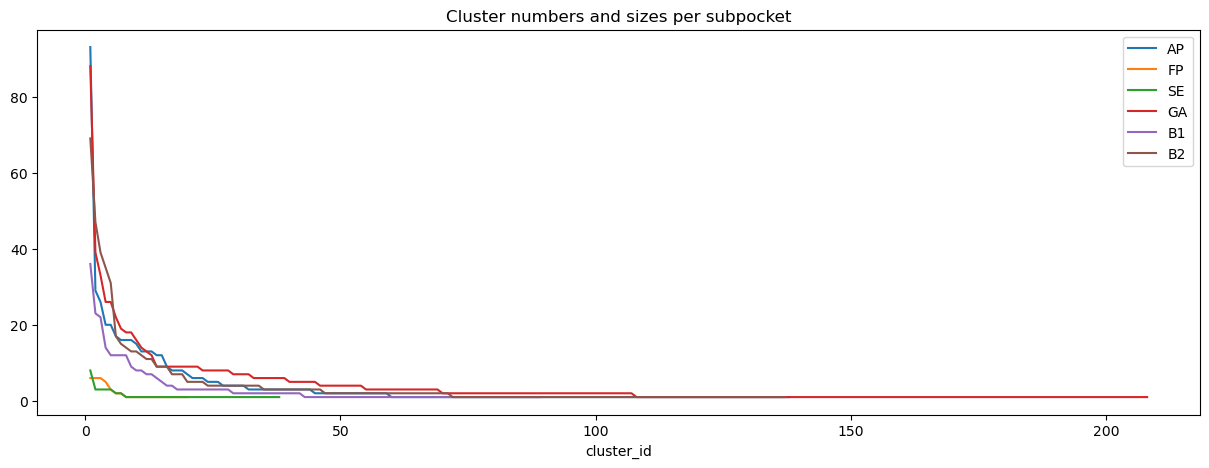

In [200]:
# Get cluster size per subpocket and cluster
cluster_data = selected_fragments.groupby(
    ['subpocket', 'cluster_id']
).first()['cluster_size'].reset_index()

# Reformat cluster data for plotting (subpocket per column)
cluster_data = pd.concat(
    [
        subpocket_data.set_index('cluster_id')['cluster_size'] 
        for subpocket, subpocket_data 
        in cluster_data.groupby('subpocket', sort=False)
    ], 
    axis=1
)
cluster_data.columns = selected_fragments.groupby('subpocket', sort=False).groups.keys()

# Plot cluster data
cluster_data.plot(figsize=(15,5), title='Cluster numbers and sizes per subpocket')

### Include singletons?

In [201]:
print(f'Number of selected fragments with singletons: {selected_fragments.shape[0]}')

if INCLUDE_SINGLETONS:
    pass
else:
    selected_fragments = selected_fragments[selected_fragments.cluster_size!=1]
    print(f'Number of selected fragments without singletons: {selected_fragments.shape[0]}')
    
print(f'Include singletons: {INCLUDE_SINGLETONS}')
print(f'Number of selected fragments in final set: {selected_fragments.shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of selected fragments with singletons: 721
Include singletons: True
Number of selected fragments in final set: 721


## 5. Look at selected fragments

### Number of fragments per subpocket and in total

In [202]:
selected_fragments.groupby('subpocket', sort=False).size()
# NBVAL_CHECK_OUTPUT

subpocket
AP    163
FP    235
SE    164
GA    101
B1     20
B2     38
dtype: int64

In [203]:
print(f'Size of reduced fragment library: {selected_fragments.shape[0]}')
# NBVAL_CHECK_OUTPUT

Size of reduced fragment library: 721


### Number of original ligands that selected fragments originate from

Each fragment is linked to the original ligand that it originated from (kinase name, complex and ligand PDB). Count how many original ligands are linked to the selected fragments.

In [204]:
selected_fragments.groupby(['complex_pdb', 'ligand_pdb']).first().shape[0]
# NBVAL_CHECK_OUTPUT

633

### Show fragments per subpocket

In [205]:
def draw_selected_fragments(selected_fragments, output_path=None):
    """
    Draw selected fragments sorted by descending cluster size (show legend cluster ID | cluster size | fragment count | cluster member ID).
    
    Parameters
    ----------
    cluster_centroids : pandas.DataFrame
        Fragments that are cluster centroids (cluster ID as index, molecule ID, cluster size, and ROMol).   
    output_path : pathlib.Path
        Path to output folder.
    
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of fragments sorted by descending cluster size.
    """
    
    subpocket = selected_fragments.subpocket.unique()[0]
        
    img = Draw.MolsToGridImage(
        list(selected_fragments.ROMol), 
        legends=[
            f'{row.cluster_id} | {row.cluster_size} | {row.fragment_count} | {row.cluster_member_id} | {row.complex_pdb} | {row.ligand_pdb}' 
            for index, row
            in selected_fragments.iterrows()
        ],  
        molsPerRow=7, 
        maxMols=200,
        subImgSize=(170, 170),
        useSVG=True
    )
    
    print(f'Legend: cluster ID | cluster size | fragment count | cluster member ID | complex PDB ID | ligand PDB ID')
    
    if output_path is not None:
        
        # Get SVG data
        molsvg = img.data

        # Set font size
        molsvg = molsvg.replace('12px', '24px');

        # Save altered SVG data to file
        with open(Path(output_path) / f'clustered_most_common_fragments_{subpocket.lower()}.svg', 'w') as f:
            f.write(molsvg)
    
    return img

#### Fragments in AP

In [206]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('AP'), output_path=None)

Legend: cluster ID | cluster size | fragment count | cluster member ID | complex PDB ID | ligand PDB ID


#### Fragments in FP

In [207]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('FP'), output_path=None)

/opt/homebrew/Caskroom/mambaforge/base/envs/kinfraglib/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 200. Change the maxMols value to display more.
  warnings.warn(


Legend: cluster ID | cluster size | fragment count | cluster member ID | complex PDB ID | ligand PDB ID


#### Fragments in SE

Legend: cluster ID | cluster size | fragment count | cluster member ID | complex PDB ID | ligand PDB ID


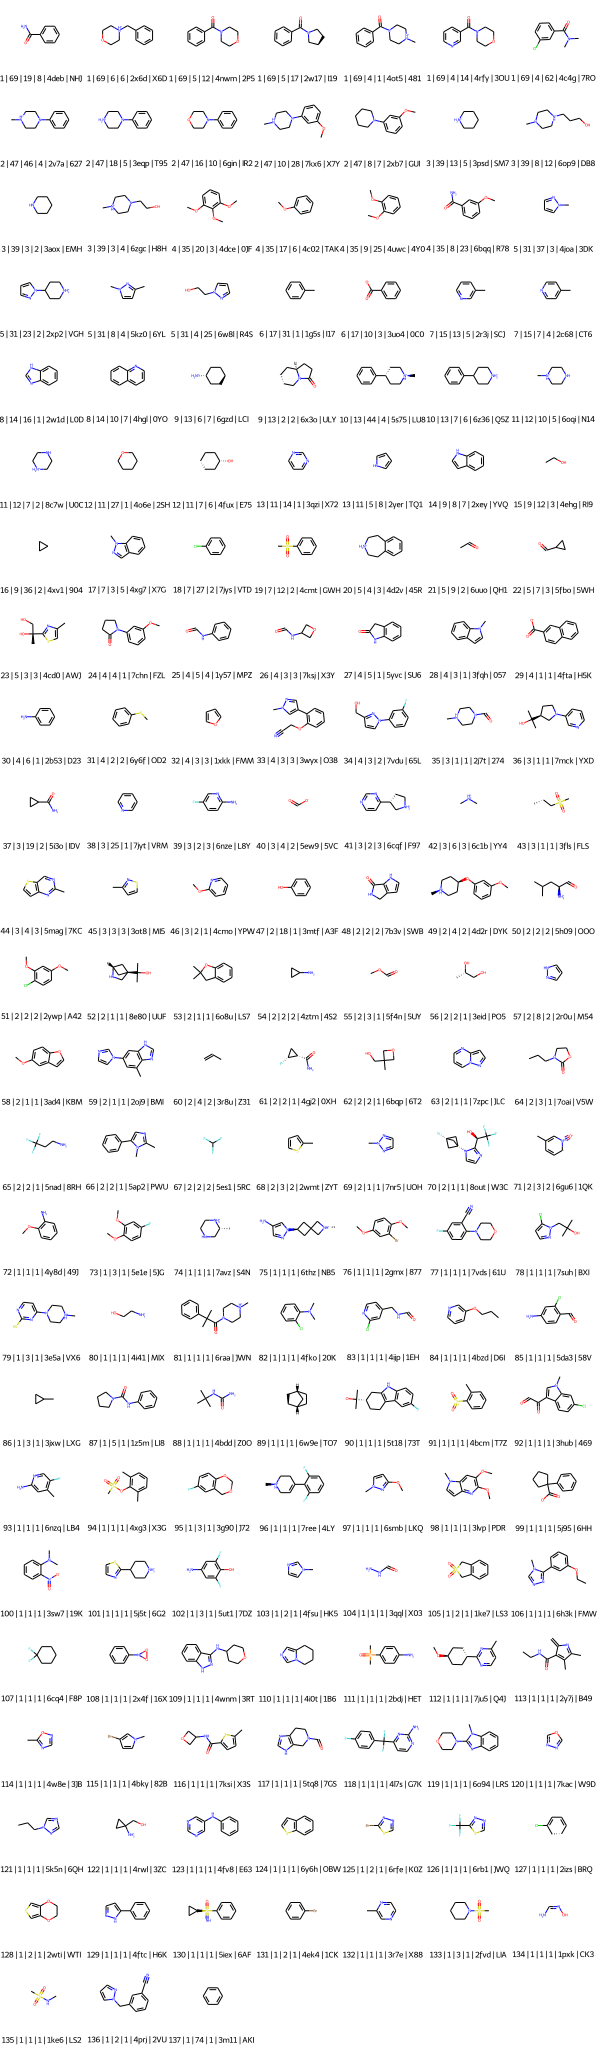

In [208]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('SE'), output_path=None)

#### Fragments in GA

Legend: cluster ID | cluster size | fragment count | cluster member ID | complex PDB ID | ligand PDB ID


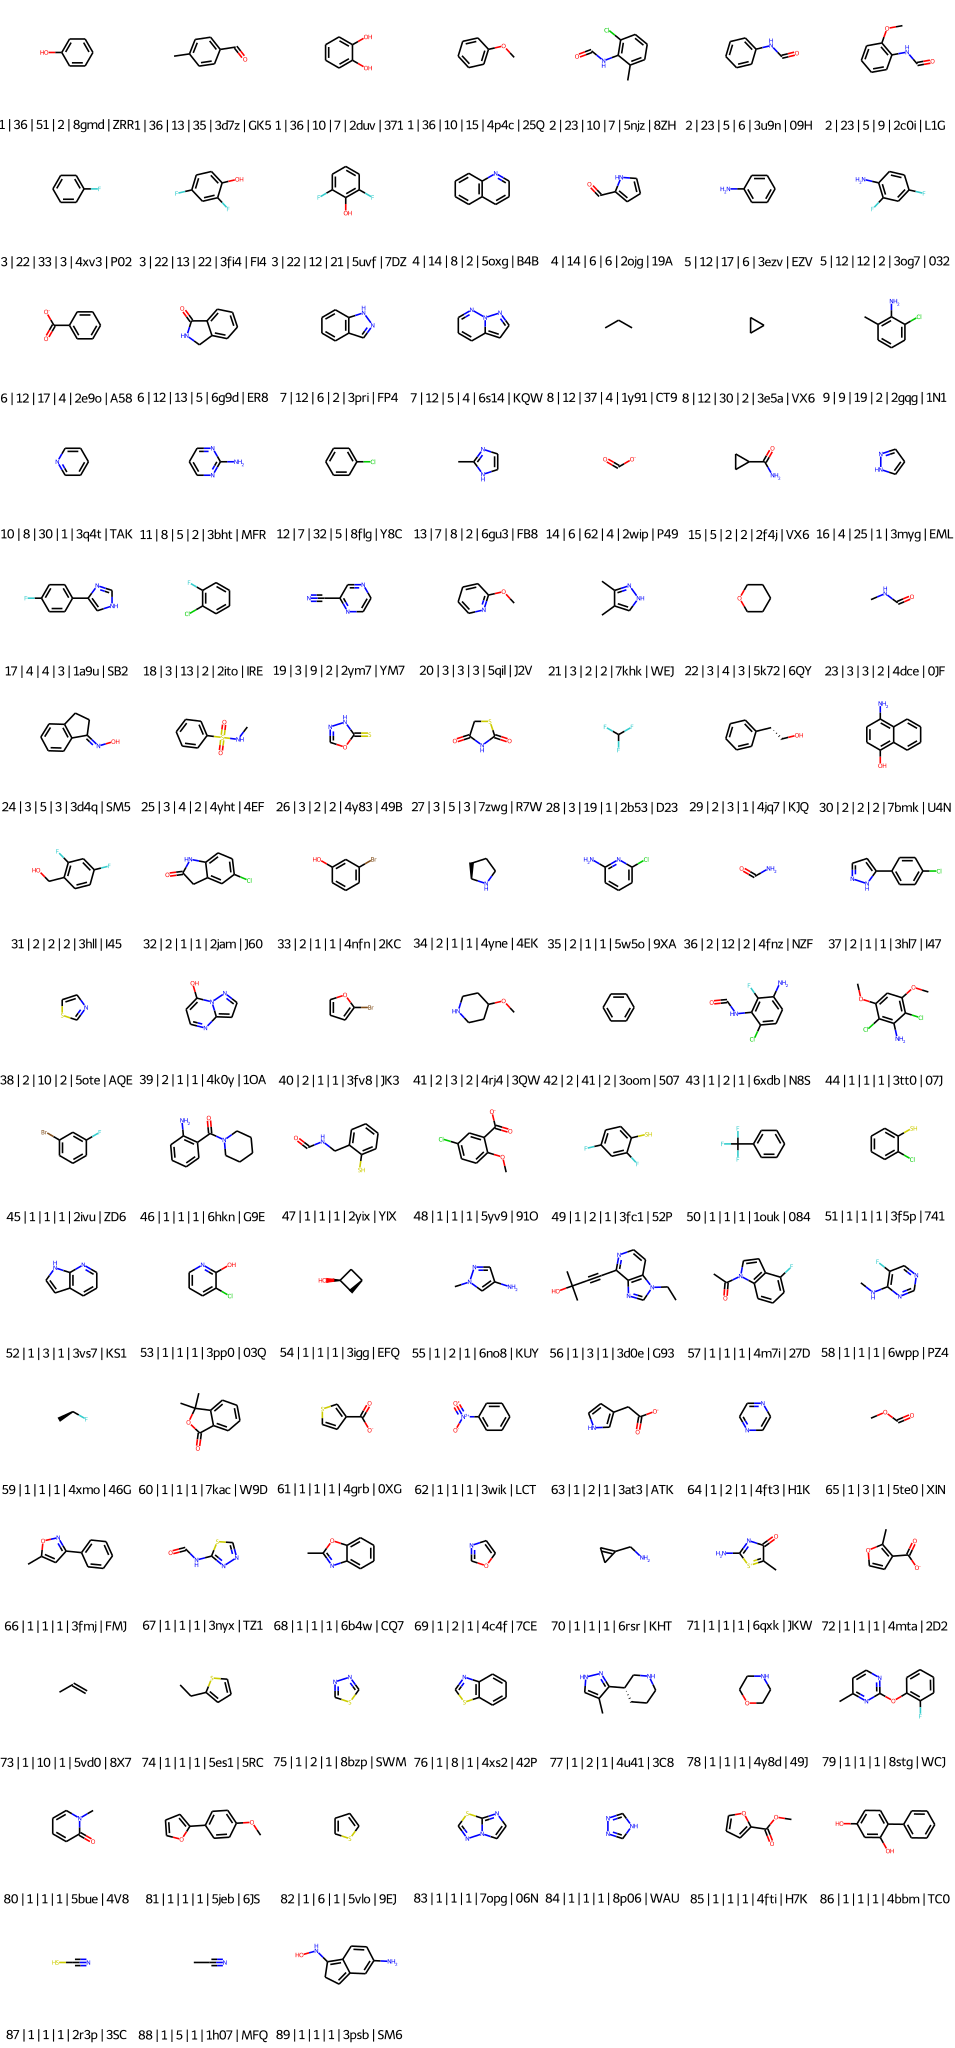

In [209]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('GA'), output_path=None)

#### Fragments in B1

Legend: cluster ID | cluster size | fragment count | cluster member ID | complex PDB ID | ligand PDB ID


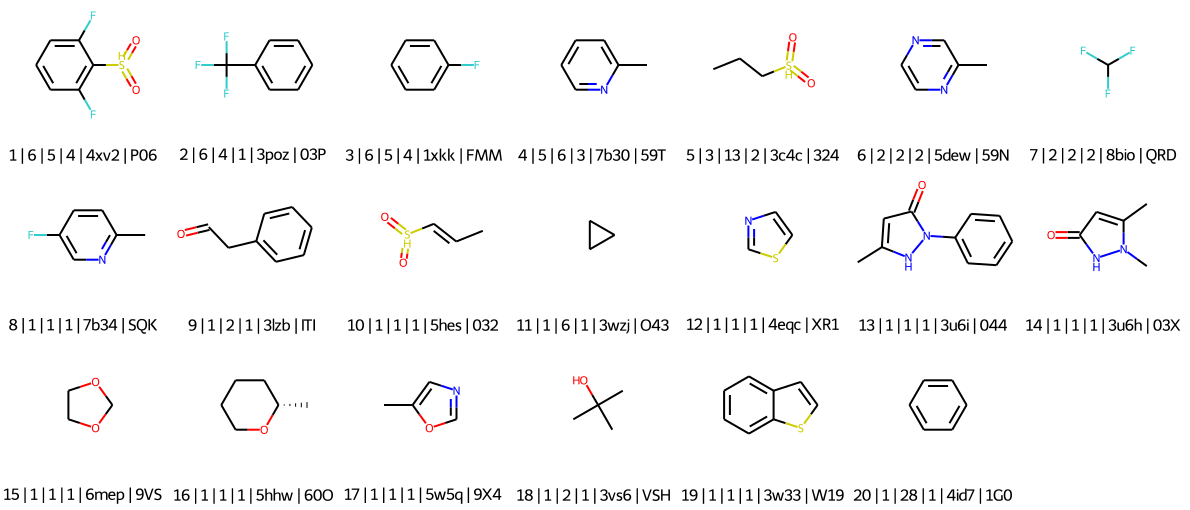

In [210]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('B1'), output_path=None)

#### Fragments in B2

Legend: cluster ID | cluster size | fragment count | cluster member ID | complex PDB ID | ligand PDB ID


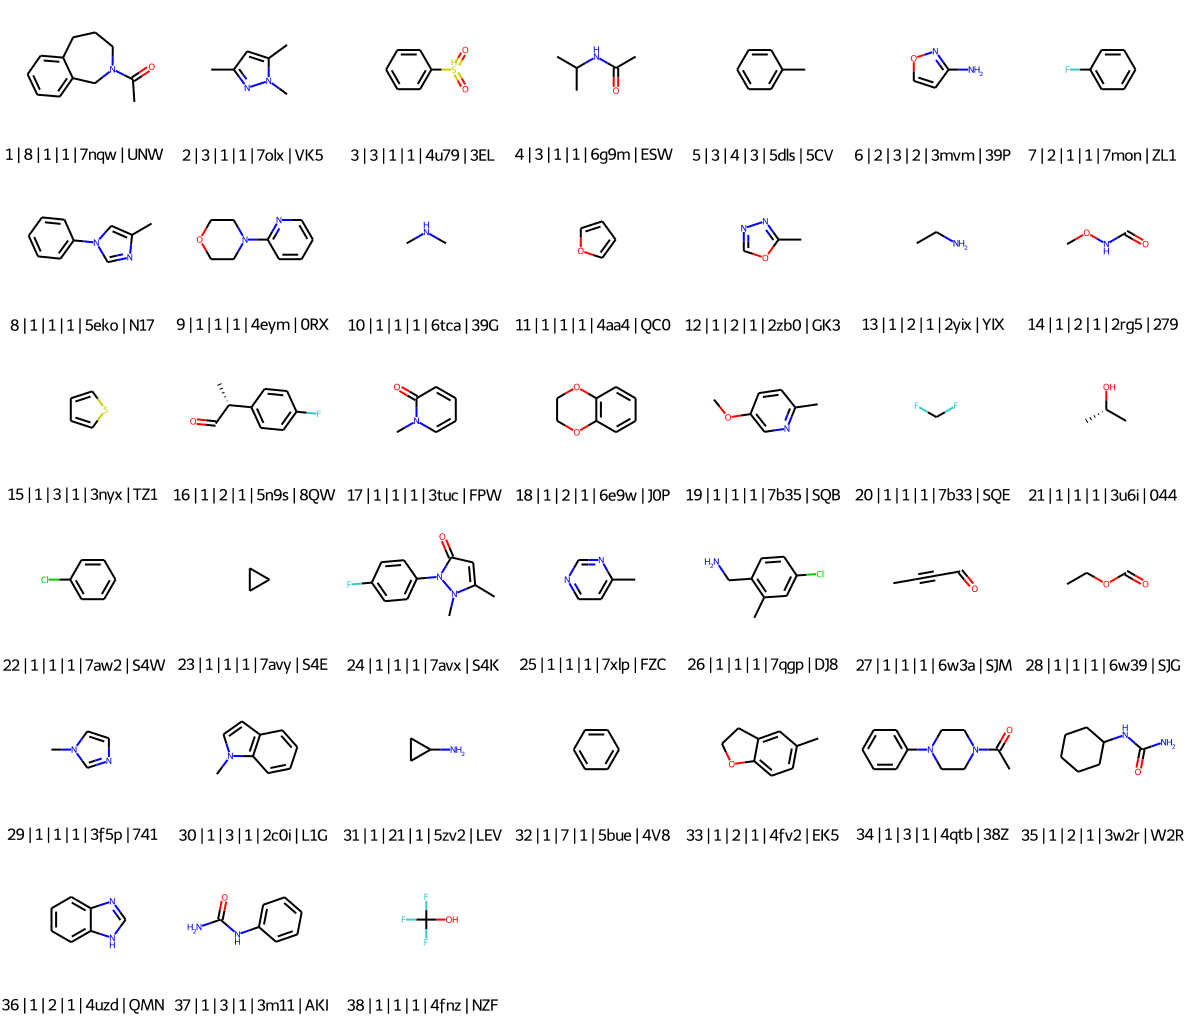

In [211]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('B2'), output_path=None)

## 6. Save reduced fragment library

After looking at all selected fragments and being content with the results, we define this set as reduced fragment library.

In [212]:
fragment_library_concat_reduced = selected_fragments

Save reduced fragment library as sdf files (one per subpocket).

In [213]:
save_fragment_library_to_sdfs(PATH_DATA / 'fragment_library_reduced', fragment_library_concat_reduced)

Add README to output folder.

In [214]:
with open(PATH_DATA / 'fragment_library_reduced' / 'README.md', 'w') as f:
    f.write(
        f'# Reduced fragment library'
        f'\n\n'
        f'The (full) fragment library resulting from the KinFragLib fragmentation procedure comprises of {fragment_library_concat.shape[0]} fragments, '
        f'which are the basis for exploring the subpocket-based chemical space of ligands co-crystallized with kinases '
        f'(see `data/fragment_library/`).'
        f'\n\n'
        f'In order to demonstrate how this library can be used for recombining ligands, '
        f'we offer here a reduced fragment library ({fragment_library_concat_reduced.shape[0]} fragments) based on the following filters:'
        f'\n\n'
        f'1. Remove all fragments that are not useful in a recombination. Check `data/fragment_library_filtered/`.\n'
        f'2. Select a diverse set of fragments (per subpocket) for recombination to '
        f'(i) save computational cost and '
        f'(ii) avoid recombination of highly similar fragments.'
        f'\n\n'
        f'Step 1 is necessary to focus on fragments tailored for the recombination, whereas step 2 mainly aims to reduce computational costs during recombination.'
        f'\n\n'
        f'## Reduction steps'
        f'\n\n'
        f'1. Perform Butina clustering per subpocket (`DISTANCE_CUTOFF`).\n'
        f'2. Select fragments from clusters: Most common fragment per cluster (if mulitple most common fragments, select the one most similar to cluster centroid)\n'
        f'  a. Select always one fragment per cluster, i.e. cluster centroid (`N_REPRESENTED_FRAGMENTS` = None).\n'
        f'  b. Select top X most common fragments per cluster, whereby X is depending on cluster size, '
        f'e.g. 10 clustered fragments will be represented by one selected fragment (`N_REPRESENTED_FRAGMENTS` = 10).\n'
        f'3. Include fragments from singleton clusters? (`INCLUDE_SINGLETONS`)'
        f'\n\n'
        f'## Selected reduction parameters'
        f'\n\n'
        f'- `DISTANCE_CUTOFF` = {DISTANCE_CUTOFF}\n'
        f'- `N_REPRESENTED_FRAGMENTS` = {N_REPRESENTED_FRAGMENTS}\n'
        f'- `INCLUDE_SINGLETONS` = {INCLUDE_SINGLETONS}'
        f'\n\n'
        f'Please refer to the notebook `notebooks/3_1_fragment_library_reduced.ipynb` to check how the data was generated and/or use it as a starting point for customized protocols.'
    )